In [1]:
using FFTW, LinearAlgebra
using BenchmarkTools
using Plots
gr()

Plots.GRBackend()

In [2]:
""" 
Class with initial data
 
Relativistic Klein-Gordon equation
 
"""
struct DataSet

    nx        :: Int64  
    epsilon   :: Float64 
    k         :: Vector{Float64}
    T         :: Float64
    Tfinal    :: Float64
    sigma     :: Int64
    llambda   :: Int64
    x         :: Array{Float64,1}
    u         :: Array{ComplexF64,1}
    v         :: Array{ComplexF64,1}
    dx        :: Float64
    
    function DataSet( dataset, xmin, xmax, nx, epsilon, Tfinal)

        k  = zeros(Float64, nx)
        k .= 2 * pi / (xmax - xmin) * vcat(0:nx÷2-1,-nx÷2:-1)
        T  = 2 * pi

        x   = zeros(Float64, nx)
        x  .= range(xmin, stop=xmax, length=nx+1)[1:end-1]
        dx  = (xmax - xmin) / nx

        phi   = zeros(ComplexF64, nx)
        gamma = zeros(ComplexF64, nx)

        phi   .= (1 + 1im) * cos.(x)
        gamma .= (1 - 1im) * sin.(x)

        sigma   = 1
        llambda = -1

        u = zeros(ComplexF64, nx)
        v = zeros(ComplexF64, nx)

        u .= phi .- 1im * ifft((1 .+ epsilon * k.^2) .^ (-1/2) .* fft(gamma))
        v .= conj.(phi) .- 1im * ifft((1 .+ epsilon * k.^2) .^ (-1/2) .* fft(conj.(gamma)))

        new(nx, epsilon, k, T, Tfinal, sigma, llambda, x, u, v, dx)

    end

end


DataSet

In [3]:
struct MicMac

    data      :: DataSet
    ntau      :: Int64
    ktau      :: Vector{Float64}
    matr      :: Vector{ComplexF64}
    A1        :: Vector{Float64}
    A2        :: Vector{Float64}

    function MicMac( data, ntau )

        nx        = data.nx
        T         = data.T
        k         = data.k

        epsilon   = data.epsilon

        llambda   = data.llambda
        sigma     = data.sigma

        tau       = zeros(Float64, ntau)
        tau      .= T * collect(0:ntau-1) / ntau
        ktau      = similar(tau)
        ktau     .= 2 * pi / T * vcat(0:ntau÷2-1,-ntau÷2:-1)
        ktau[1]   = 1.0

        matr      = zeros(ComplexF64,ntau)
        matr     .= exp.( 1im * tau)

        A1 = zeros(Float64, nx)
        A2 = zeros(Float64, nx)

        if epsilon > 0
            A1 .= (sqrt.(1 .+ epsilon * k.^2) .- 1) / epsilon
            A2 .= (1 .+ epsilon * k.^2) .^ (-1/2)
        else
            A1 .= 0.5 * k .^ 2
            A2 .= 1.0
        end

        new( data, ntau, ktau, matr, A1 , A2)

    end

end

In [4]:
function ftau!(
        champu::Array{ComplexF64,2}, 
        champv::Array{ComplexF64,2}, 
        m :: MicMac, 
        t, 
        fft_u::Vector{ComplexF64}, 
        fft_v::Vector{ComplexF64})

    llambda  = m.data.llambda
    sigma    = m.data.sigma
    matr     = m.matr
    conjmatr = conj.(matr)

    champu .= matr .* transpose(ifft(exp.(1im * t * m.A1) .* fft_u))
    champv .= matr .* transpose(ifft(exp.(1im * t * m.A1) .* fft_v))

    z = ( champu .+ conj.(champv)) / 2

    fz1  = abs.(z) .^ (2*sigma) .* z

    champu .= conjmatr .* fz1
    champv .= conjmatr .* conj.(fz1)

    fft!(champu,2)
    fft!(champv,2)

    champu .*= transpose(-1im * llambda * m.A2 .* exp.(-1im * t * m.A1))
    champv .*= transpose(-1im * llambda * m.A2 .* exp.(-1im * t * m.A1))

end

ftau! (generic function with 1 method)

In [21]:
function ftau(m, t, fft_u, fft_v)
    
    llambda  = m.data.llambda
    sigma    = m.data.sigma
    matr     = m.matr
    conjmatr = conj.(matr)

    u = ifft(transpose(exp.(1im * t * m.A1)) .* fft_u,2) .* m.matr
    v = ifft(transpose(exp.(1im * t * m.A1)) .* fft_v,2) .* m.matr

    z = (u .+ conj.(v)) / 2

    fz1 = abs.(z) .^ (2 * sigma) .* z

    u = -1im * llambda * m.A2 .* exp.(-1im * t * m.A1) 
    v = -1im * llambda * m.A2 .* exp.(-1im * t * m.A1) 

    u = transpose(u) .* fft(conjmatr .* fz1, 2)
    v = transpose(v) .* fft(conjmatr .* conj.(fz1), 2)

    u, v

end

ftau (generic function with 1 method)

In [22]:
function C1!(champu, champv, m :: MicMac, t, fft_u, fft_v) 

    ftau!(champu, champv, m, t, fft_u, fft_v)

    fft!(champu, 1)
    fft!(champv, 1)

    champu[1, :] .= 0.0
    champv[1, :] .= 0.0

    champu ./= (1im * m.ktau)
    champv ./= (1im * m.ktau)

    ifft!(champu, 1)
    ifft!(champv, 1)

    epsilon   = m.data.epsilon

    champu .= transpose(fft_u) .+ epsilon * champu
    champv .= transpose(fft_v) .+ epsilon * champv

end

C1! (generic function with 1 method)

In [23]:
function duftau(m :: MicMac, t, fft_u, fft_v, fft_du, fft_dv)

    sigma    = 1
    llambda  = m.data.llambda
    matr     = m.matr
    conjmatr = conj.(matr)

    u = ifft(transpose(exp.(1im * t .* m.A1) .* fft_u) .* matr, 2)
    v = ifft(transpose(exp.(1im * t .* m.A1) .* fft_v) .* matr, 2)

    du = ifft(transpose(exp.(1im * t .* m.A1) .* fft_du) .* matr, 2)
    dv = ifft(transpose(exp.(1im * t .* m.A1) .* fft_dv) .* matr, 2)

    z  = (u  .+ conj.(v) ) / 2
    dz = (du .+ conj.(dv)) / 2

    fz1 = 2 * abs.(z) .^ 2 .* dz .+ z .^ 2 .* conj.(dz)

    champu = transpose(-1im * llambda * m.A2 .* exp.(-1im * t .* m.A1)) .* fft(conjmatr .* fz1, 2)
    champv = transpose(-1im * llambda * m.A2 .* exp.(-1im * t .* m.A1)) .* fft(conjmatr .* conj.(fz1), 2)

    champu, champv

end

duftau (generic function with 1 method)

In [24]:
function dtftau(m :: MicMac, t, fft_u, fft_v )

    sigma    = 1
    llambda  = m.data.llambda
    matr     = m.matr
    conjmatr = conj.(matr)

    u  = ifft(transpose(exp.(1im * t .* m.A1) .* fft_u).* matr, 2)
    v  = ifft(transpose(exp.(1im * t .* m.A1) .* fft_v).* matr, 2)

    du = transpose(ifft(exp.(1im * t .* m.A1) .* (1im .* m.A1) .* fft_u)) .* matr
    dv = transpose(ifft(exp.(1im * t .* m.A1) .* (1im .* m.A1) .* fft_v)) .* matr

    z  = (u  .+ conj.(v) ) / 2
    dz = (du .+ conj.(dv)) / 2

    fz1 = 2 * abs.(z) .^ 2 .* dz .+ z .^ 2 .* conj.(dz)
    champu1 = transpose(-1im * llambda * m.A2 .* exp.(-1im * t .* m.A1)) .* fft(conjmatr .* fz1, 2)
    champv1 = transpose(-1im * llambda * m.A2 .* exp.(-1im * t .* m.A1)) .* fft(conjmatr .* conj.(fz1), 2)

    fz1 = abs.(z) .^ 2 .* z
    champu2 = transpose(-1im * llambda * m.A2 .* exp.(-1im * t * m.A1) .* (-1im * m.A1)) .* fft(conjmatr .* fz1, 2)
    champv2 = transpose(-1im * llambda * m.A2 .* exp.(-1im * t * m.A1) .* (-1im * m.A1)) .* fft(conjmatr .* conj.(fz1), 2)

    champu1 .+ champv1, champu2 .+ champv2

end

dtftau (generic function with 1 method)

In [31]:
function champs_2(champu, champv, m :: MicMac, t, fft_ubar, fft_vbar, fft_ug, fft_vg)

    sigma    = 1
    llambda  = m.data.llambda
    epsilon  = m.data.epsilon
    matr     = m.matr
    conjmatr = conj.(matr)
    nx       = m.data.nx

    ftau!(champu, champv, m, t, fft_ubar, fft_vbar)

    fft!(champu, 1)
    fft!(champv, 1)

    champu[1, :] .= 0.0
    champv[1, :] .= 0.0

    dtauh1u = ifft(champu, 1)
    dtauh1v = ifft(champv, 1)

    h1u = epsilon * ifft(champu ./ (1im * m.ktau), 1)
    h1v = epsilon * ifft(champv ./ (1im * m.ktau), 1)

    C1u = transpose(fft_ubar) .+ h1u
    C1v = transpose(fft_vbar) .+ h1v

    ffu, ffv = ftau( m, t, 
        C1u .+ transpose(fft_ug), 
        C1v .+ transpose(fft_vg))

    champu, champv = ftau( m, t, C1u, C1v)

    fft!(champu, 1)
    fft!(champv, 1)
    
    champubaru = zeros(ComplexF64,nx)
    champubarv = zeros(ComplexF64,nx)

    champubaru .= champu[1, :] ./ m.ntau
    champubarv .= champv[1, :] ./ m.ntau

    champu1, champv1 = duftau(m, t, fft_ubar, fft_vbar, champubaru, champubarv)
    champu2, champv2 = dtftau(m, t, fft_ubar, fft_vbar)

    champu .= fft(champu1 .+ champu2, 1)
    champv .= fft(champv1 .+ champv2, 1)

    champu[1, :] .= 0.0
    champv[1, :] .= 0.0

    champu = transpose(champubaru) .+ epsilon * ifft(champu ./ (1im * m.ktau), 1)
    champv = transpose(champubarv) .+ epsilon * ifft(champv ./ (1im * m.ktau), 1)

    champu .= ffu .- dtauh1u .- champu
    champv .= ffv .- dtauh1v .- champv

    fft!(champu, 1)
    fft!(champv, 1)

    champmoyu = zeros(ComplexF64,nx)
    champmoyv = zeros(ComplexF64,nx)
    
    champmoyu .= champu[1, :] ./ m.ntau
    champmoyv .= champv[1, :] ./ m.ntau

    champu[1, :] .= 0.0 
    champv[1, :] .= 0.0

    champu .= champu ./ (1im * m.ktau)
    champv .= champv ./ (1im * m.ktau)

    ifft!(champu, 1)
    ifft!(champv, 1)

    champubaru, champubarv, champu, champv, champmoyu, champmoyv

end

champs_2 (generic function with 1 method)

In [32]:
function reconstr(u, t, T, ntau)

    w   = zeros(ComplexF64, ntau)
    w  .= vcat(0:ntau÷2-1,-ntau÷2:-1)
    w  .= exp.(1im * 2π / T * w * t)
    v   = fft(u,1)

    vec(sum(v .* w, dims=1) / ntau)

end

reconstr (generic function with 1 method)

In [33]:
function solve(m :: MicMac, dt)

    Tfinal    = m.data.Tfinal
    nx        = m.data.nx
    ntau      = m.ntau
    T         = m.data.T
    k         = m.data.k

    fft_u = zeros(ComplexF64,nx)
    fft_v = zeros(ComplexF64,nx)

    fft_u .= m.data.u
    fft_v .= m.data.v

    fft_ubar    = similar(fft_u)
    fft_vbar    = similar(fft_v)
    fft_ubar12  = similar(fft_u)
    fft_vbar12  = similar(fft_v)

    fft_ug      = similar(fft_u)
    fft_vg      = similar(fft_v)
    fft_ug12    = similar(fft_u)
    fft_vg12    = similar(fft_v)
    fft_ugbar12 = similar(fft_u)
    fft_vgbar12 = similar(fft_v)

    champu = zeros(ComplexF64,(ntau,nx))
    champv = zeros(ComplexF64,(ntau,nx))
    
    ichampu = zeros(ComplexF64,(ntau,nx))
    ichampv = zeros(ComplexF64,(ntau,nx))

    epsilon   = m.data.epsilon
    dx        = m.data.dx
    llambda   = m.data.llambda
    sigma     = m.data.sigma

    t    = 0.0
    iter = 0

    fft!(fft_u)
    fft!(fft_v)

    ftau!(champu, champv, m, t, fft_u, fft_v)

    fft!(champu, 1)
    fft!(champv, 1)

    champu[1, :] .= 0.0
    champv[1, :] .= 0.0

    champu ./= (1im * m.ktau)
    champv ./= (1im * m.ktau)

    ifft!(champu, 1)
    ifft!(champv, 1)

    fft_ubar .= fft_u .- epsilon * champu[1, :]
    fft_vbar .= fft_v .- epsilon * champv[1, :]

    C1!(champu, champv, m, 0.0, fft_ubar, fft_vbar)

    fft_ug .= fft_u .- champu[1, :]
    fft_vg .= fft_v .- champv[1, :]

    while t < Tfinal

        iter += 1
        dt    = min(Tfinal-t, dt)

        champubaru, champubarv, ichampgu, ichampgv, champmoyu, champmoyv = ( 
            champs_2(champu, champv, m, t, 
                     fft_ubar, fft_vbar, fft_ug, fft_vg) )

        fft_ubar12 .= fft_ubar .+ dt/2 * champubaru
        fft_vbar12 .= fft_vbar .+ dt/2 * champubarv

        fft_ug12  .= (fft_ug 
	              .+ epsilon * reconstr(ichampgu, (t+dt/2)/epsilon, T, ntau) 
                  .- epsilon * reconstr(ichampgu, t/epsilon, T, ntau) 
                  .+ dt/2 * champmoyu)

        fft_vg12  .= (fft_vg 
                  .+ epsilon * reconstr(ichampgv, (t+dt/2)/epsilon, T, ntau) 
                  .- epsilon * reconstr(ichampgv, t/epsilon, T, ntau) 
                  .+ dt/2 * champmoyv)

        champubaru, champubarv, ichampgu, ichampgv, champmoyu, champmoyv = (
            champs_2(champu, champv, m, t+dt/2, 
                     fft_ubar12, fft_vbar12, fft_ug12, fft_vg12))

        fft_ubar .+= dt * champubaru
        fft_vbar .+= dt * champubarv
        
        fft_ug .= ( fft_ug 
               .+ epsilon * reconstr(ichampgu, (t+dt)/epsilon, T, ntau) 
               .- epsilon * reconstr(ichampgu, t/epsilon, T, ntau) 
               .+ dt * champmoyu )
        
        fft_vg .= ( fft_vg
               .+ epsilon * reconstr(ichampgv, (t+dt)/epsilon, T, ntau) 
               .- epsilon * reconstr(ichampgv, t/epsilon, T, ntau) 
               .+ dt * champmoyv )
        
        t += dt
        
        C1!(champu, champv, m, t, fft_ubar, fft_vbar)
        
        fft_u .= reconstr(champu, t / epsilon, T, ntau)
        fft_v .= reconstr(champv, t / epsilon, T, ntau)
        
        fft_u .+= fft_ug
        fft_v .+= fft_vg

    end

    fft_u .= exp.(1im * sqrt.(1 .+ epsilon * k.^2) * t / epsilon) .* fft_u
    fft_v .= exp.(1im * sqrt.(1 .+ epsilon * k.^2) * t / epsilon) .* fft_v

    ifft!(fft_u)
    ifft!(fft_v)

    fft_u, fft_v

end

solve (generic function with 1 method)

In [34]:
function reconstr_x(uv, x)
    N  = size(uv)[2]
    nx = size(x)[1]
    L  = x[end] - x[1]
    UA = zeros(ComplexF64, (4, nx))
    v  = fft(uv, 2) / N
    for jj in 1:N÷2
        vv = v[:, jj]
        UA .= UA .+ vv .* exp.(1im * 2 * pi / L * (jj-1) * (x' .- xmin))
    end
    
    for jj in N÷2:N
        vv = v[:, jj]
        UA = UA .+ vv .* exp.(1im * 2 * pi / L * (jj-1-N) * (x' .- xmin))
    end

    UA
end

reconstr_x (generic function with 1 method)

In [37]:
function compute_error(u, v, epsilon, dataset)

    str0 = ["donnees_cubique_128_micmac/",
            "donnees_FS_128_micmac/",
            "donnees_data3_128_micmac/"]

    str3 = "donnee_"
    str5 = ".txt"

    if (epsilon == 10       )  str4 = "10"        end
    if (epsilon == 5        )  str4 = "5"         end
    if (epsilon == 2.5      )  str4 = "2_5"       end
    if (epsilon == 1        )  str4 = "1"         end
    if (epsilon == 0.5      )  str4 = "0_5"       end
    if (epsilon == 0.2      )  str4 = "0_2"       end
    if (epsilon == 0.25     )  str4 = "0_25"      end
    if (epsilon == 0.1      )  str4 = "0_1"       end
    if (epsilon == 0.05     )  str4 = "0_05"      end
    if (epsilon == 0.025    )  str4 = "0_025"     end
    if (epsilon == 0.01     )  str4 = "0_01"      end
    if (epsilon == 0.005    )  str4 = "0_005"     end
    if (epsilon == 0.0025   )  str4 = "0_0025"    end
    if (epsilon == 0.001    )  str4 = "0_001"     end
    if (epsilon == 0.0005   )  str4 = "0_0005"    end
    if (epsilon == 0.00025  )  str4 = "0_00025"   end
    if (epsilon == 0.0001   )  str4 = "0_0001"    end
    if (epsilon == 0.00005  )  str4 = "0_00005"   end
    if (epsilon == 0.000025 )  str4 = "0_000025"  end
    if (epsilon == 0.00001  )  str4 = "0_00001"   end
    if (epsilon == 0.000005 )  str4 = "0_000005"  end
    if (epsilon == 0.0000025)  str4 = "0_0000025" end
    if (epsilon == 0.000001 )  str4 = "0_000001"  end

    ref_file = joinpath("test", str0[dataset], str3 * str4 * str5)

    uv = zeros(Float64, (4, 128))

    open(ref_file) do f

        for (j,line) in enumerate(eachline(f))
            for (i, val) in enumerate( [ parse(Float64, val) for val in split(line)]) 
                uv[i, j] = val
            end
        end

    end

    nx   = size(u)[1]
    xmin = 0
    xmax = 2π
    T    = 2π
    t    = 0.25

    dx = (xmax - xmin) / nx
    x  = collect(range(xmin, stop=xmax, length=nx+1)[1:end-1])
    k  = collect(2π / (xmax - xmin) * vcat(0:nx÷2-1,-nx÷2:-1))

    uv = reconstr_x(uv, x)

    uref = vec(uv[1, :] .+ 1im * uv[2, :])
    vref = vec(uv[3, :] .+ 1im * uv[4, :])
    
    refH1 = sqrt(dx * norm(ifft(1im * sqrt.(1 .+ k.^2) .* fft(uref)))^2 
               + dx * norm(ifft(1im * sqrt.(1 .+ k.^2) .* fft(vref)))^2)

    err  = (sqrt(dx * norm(ifft(1im * sqrt.(1 .+ k.^2) .* fft(u .- uref)))^2 
               + dx * norm(ifft(1im * sqrt.(1 .+ k.^2) .* fft(v .- uref)))^2)) / refH1

    err

end

compute_error (generic function with 1 method)

In [40]:
dataset  = 3
xmin     = 0
xmax     = 2π
T        = 2π
nx       = 64
ntau     = 32
tfinal   = 0.25
epsilon  = 0.1

data = DataSet(dataset, xmin, xmax, nx, epsilon, tfinal)

dt = 2.0^(-3) * tfinal / 16

m = MicMac(data, ntau)

@time u, v = solve(m, dt)

compute_error(u, v, epsilon, dataset)

  0.921234 seconds (763.55 k allocations: 1007.457 MiB, 18.51% gc time)


1.0011039458571287

In [44]:
function read_refdata(epsilon, dataset)

    str0 = ["donnees_cubique_128_micmac/",
            "donnees_FS_128_micmac/",
            "donnees_data3_128_micmac/"]

    str3 = "donnee_"
    str5 = ".txt"

    if (epsilon == 10       )  str4 = "10"        end
    if (epsilon == 5        )  str4 = "5"         end
    if (epsilon == 2.5      )  str4 = "2_5"       end
    if (epsilon == 1        )  str4 = "1"         end
    if (epsilon == 0.5      )  str4 = "0_5"       end
    if (epsilon == 0.2      )  str4 = "0_2"       end
    if (epsilon == 0.25     )  str4 = "0_25"      end
    if (epsilon == 0.1      )  str4 = "0_1"       end
    if (epsilon == 0.05     )  str4 = "0_05"      end
    if (epsilon == 0.025    )  str4 = "0_025"     end
    if (epsilon == 0.01     )  str4 = "0_01"      end
    if (epsilon == 0.005    )  str4 = "0_005"     end
    if (epsilon == 0.0025   )  str4 = "0_0025"    end
    if (epsilon == 0.001    )  str4 = "0_001"     end
    if (epsilon == 0.0005   )  str4 = "0_0005"    end
    if (epsilon == 0.00025  )  str4 = "0_00025"   end
    if (epsilon == 0.0001   )  str4 = "0_0001"    end
    if (epsilon == 0.00005  )  str4 = "0_00005"   end
    if (epsilon == 0.000025 )  str4 = "0_000025"  end
    if (epsilon == 0.00001  )  str4 = "0_00001"   end
    if (epsilon == 0.000005 )  str4 = "0_000005"  end
    if (epsilon == 0.0000025)  str4 = "0_0000025" end
    if (epsilon == 0.000001 )  str4 = "0_000001"  end

    ref_file = joinpath("test", str0[dataset], str3 * str4 * str5)

    uv = zeros(Float64, (4, 128))

    open(ref_file) do f

        for (j,line) in enumerate(eachline(f))
            for (i, val) in enumerate( [ parse(Float64, val) for val in split(line)]) 
                uv[i, j] = val
            end
        end

    end

    nx   = size(u)[1]
    xmin = 0
    xmax = 2π
    T    = 2π
    t    = 0.25

    dx = (xmax - xmin) / nx
    x  = collect(range(xmin, stop=xmax, length=nx+1)[1:end-1])
    k  = collect(2π / (xmax - xmin) * vcat(0:nx÷2-1,-nx÷2:-1))

    uv = reconstr_x(uv, x)

    uref = vec(uv[1, :] .+ 1im * uv[2, :])
    vref = vec(uv[3, :] .+ 1im * uv[4, :])

    uref, vref

end


read_refdata (generic function with 1 method)

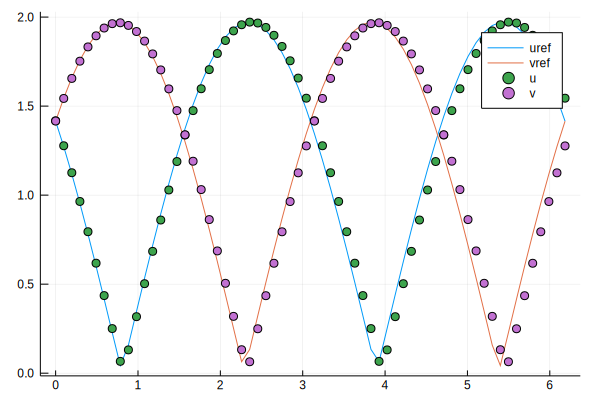

In [45]:
uref, vref = read_refdata( epsilon, dataset)
            
plot( data.x, abs.(uref), label=:uref)
plot!( data.x, abs.(vref), label=:vref)
scatter!(data.x, abs.(vec(u)), label=:u)
scatter!(data.x, abs.(vec(v)), label=:v)